# 🧱 Big Chimnie

# 🚂 1. Imports

In [2]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import geopandas as gpd
import matplotlib

# Initialize Spark session
spark = SparkSession.builder.appName("ChimnieDataAnalysis").getOrCreate()

# Print versions to verify installation
print("PySpark version:", pyspark.__version__)
print("Pandas version:", pd.__version__)
print("GeoPandas version:", gpd.__version__)
print("Matplotlib version:", matplotlib.__version__)

# Test a simple DataFrame creation in PySpark
data = [("James", "Smith"), ("Anna", "Rose"), ("Robert", "Williams")]
columns = ["FirstName", "LastName"]
df = spark.createDataFrame(data, columns)
df.show()

24/07/23 17:22:53 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


PySpark version: 3.5.1
Pandas version: 2.2.2
GeoPandas version: 1.0.1
Matplotlib version: 3.9.1


+---------+--------+
|FirstName|LastName|
+---------+--------+
|    James|   Smith|
|     Anna|    Rose|
|   Robert|Williams|
+---------+--------+



# 🥸 2. Data Sources

## Data Review

In [3]:
import os
from pyspark.sql import SparkSession
import geopandas as gpd

# Define the paths to the directories and files
land_registry_file = 'data/01-pp-complete.csv'
nspl_directory = 'data/02-NSPL_2021_MAY_2024'
osgb_directory = 'data/03-OSGB_Grids-master/Shapefile'
log_directory = 'data/data_log'

# Ensure the log directory exists
os.makedirs(log_directory, exist_ok=True)

# Initialize Spark session
spark = SparkSession.builder \
    .appName("DataReview") \
    .config("spark.executor.cores", "8") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Helper function to load and inspect files
def load_and_inspect_file(file_path, file_type):
    if file_type == 'csv':
        df = spark.read.csv(file_path, header=True, inferSchema=True)
        df.show(10)
    elif file_type == 'shp':
        gdf = gpd.read_file(file_path)
        print(f"\n{file_path} - First 10 rows:\n", gdf.head(10))
    else:
        print(f"Unsupported file type: {file_type}")

# Load and inspect the Land Registry CSV file
load_and_inspect_file(land_registry_file, 'csv')

# Inspect the NSPL directory
nspl_files = [os.path.join(nspl_directory, f) for f in os.listdir(nspl_directory) if f.endswith('.csv') or f.endswith('.txt')]
for file in nspl_files:
    file_type = 'csv' if file.endswith('.csv') else 'txt'
    load_and_inspect_file(file, file_type)

# Inspect the OSGB shapefiles directory
osgb_files = [os.path.join(osgb_directory, f) for f in os.listdir(osgb_directory) if f.endswith('.shp')]
for file in osgb_files:
    load_and_inspect_file(file, 'shp')

# Log report generation
log_report = {
    'Land Registry File': land_registry_file,
    'NSPL Files': nspl_files,
    'OSGB Shapefiles': osgb_files
}

# Generate statistics for the directories
nspl_stats = {
    'Total CSV Files': sum(1 for f in os.listdir(nspl_directory) if f.endswith('.csv')),
    'Total TXT Files': sum(1 for f in os.listdir(nspl_directory) if f.endswith('.txt'))
}

osgb_stats = {
    'Total SHP Files': sum(1 for f in os.listdir(osgb_directory) if f.endswith('.shp'))
}

log_report['NSPL Statistics'] = nspl_stats
log_report['OSGB Statistics'] = osgb_stats

# Save the log report to a file
log_report_file = os.path.join(log_directory, 'data_inspection_log.txt')
with open(log_report_file, 'w') as f:
    for key, value in log_report.items():
        f.write(f"{key}:\n")
        if isinstance(value, list):
            for item in value:
                f.write(f"  {item}\n")
        elif isinstance(value, dict):
            for sub_key, sub_value in value.items():
                f.write(f"  {sub_key}:\n    {sub_value}\n")
        else:
            f.write(f"  {value}\n")
        f.write("\n")

print(f"Log report saved to: {log_report_file}")

# Stop the Spark session
spark.stop()


24/07/23 17:22:56 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/07/23 17:23:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: {109BBF80-1E51-4910-8E2C-B124E1117A7A}, 34950, 1995-06-09 00:00, BA3 3AH, F, N, L, COOMBEND HOUSE, 7, COOMBEND, RADSTOCK, RADSTOCK, WANSDYKE, AVON, A, A
 Schema: {109BBF80-1E51-4910-8E2C-B124E1117A7A}, 34950, 1995-06-09 00:00, BA3 3AH, F, N, L, COOMBEND HOUSE, 7, COOMBEND, RADSTOCK10, RADSTOCK11, WANSDYKE, AVON, A14, A15
Expected: RADSTOCK10 but found: RADSTOCK
CSV file: file:///Users/ps/Documents/code/032interview/069chimnie%20/data/01-pp-complete.csv


+--------------------------------------+------+-------------------+--------+---+---+---+--------------+--------------+--------------------+---------------+---------------+--------------------+--------------+---+---+
|{109BBF80-1E51-4910-8E2C-B124E1117A7A}| 34950|   1995-06-09 00:00| BA3 3AH|  F|  N|  L|COOMBEND HOUSE|             7|            COOMBEND|     RADSTOCK10|     RADSTOCK11|            WANSDYKE|          AVON|A14|A15|
+--------------------------------------+------+-------------------+--------+---+---+---+--------------+--------------+--------------------+---------------+---------------+--------------------+--------------+---+---+
|                  {D5233D67-2975-42...|133000|1995-06-19 00:00:00|SW18 5AG|  T|  N|  F|           142|          NULL|   ASTONVILLE STREET|         LONDON|         LONDON|          WANDSWORTH|GREATER LONDON|  A|  A|
|                  {718BD35C-25E1-43...| 83000|1995-08-21 00:00:00|IP11 7PU|  D|  N|  F|             3|          NULL|       GARFIELD RO

## Reload Data with Correct Schema

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType

# Initialize Spark session (modify it bsaed in your resources)
spark = SparkSession.builder \
    .appName("LandRegistryErrorDetection") \
    .config("spark.executor.cores", "8") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

# Define the schema explicitly
schema = StructType([
    StructField("ID", StringType(), True),
    StructField("Price", IntegerType(), True),
    StructField("Date", TimestampType(), True),
    StructField("Postcode", StringType(), True),
    StructField("PropertyType", StringType(), True),
    StructField("Old/New", StringType(), True),
    StructField("Duration", StringType(), True),
    StructField("PAON", StringType(), True),
    StructField("SAON", StringType(), True),
    StructField("Street", StringType(), True),
    StructField("Locality", StringType(), True),
    StructField("Town/City", StringType(), True),
    StructField("District", StringType(), True),
    StructField("County", StringType(), True),
    StructField("PPDCategoryType", StringType(), True),
    StructField("RecordStatus", StringType(), True)
])

# Load the complete Land Registry dataset with the schema
land_registry_file = 'data/01-pp-complete.csv'
land_registry_df = spark.read.csv(land_registry_file, header=False, schema=schema)

# Show the schema to inspect column names
land_registry_df.printSchema()
land_registry_df.show(5)


root
 |-- ID: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- PropertyType: string (nullable = true)
 |-- Old/New: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- PAON: string (nullable = true)
 |-- SAON: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- Locality: string (nullable = true)
 |-- Town/City: string (nullable = true)
 |-- District: string (nullable = true)
 |-- County: string (nullable = true)
 |-- PPDCategoryType: string (nullable = true)
 |-- RecordStatus: string (nullable = true)

+--------------------+------+-------------------+--------+------------+-------+--------+--------------+----+-----------------+----------+----------+---------------+--------------+---------------+------------+
|                  ID| Price|               Date|Postcode|PropertyType|Old/New|Duration|          PAON|SAON|           Street|  Locality| Town/City|   

# 🏃 3. Exercises

## 3.1. Task: Identify Potential Errors in Land Registry Records

In [9]:
from pyspark.sql.functions import col

# Check for unusually high or low prices
outliers = land_registry_df.filter((col('Price') < 1000) | (col('Price') > 1e7))
outliers.show(2)

+--------------------+-----+-------------------+--------+------------+-------+--------+----+----+---------------+--------+----------+-----------------+------------------+---------------+------------+
|                  ID|Price|               Date|Postcode|PropertyType|Old/New|Duration|PAON|SAON|         Street|Locality| Town/City|         District|            County|PPDCategoryType|RecordStatus|
+--------------------+-----+-------------------+--------+------------+-------+--------+----+----+---------------+--------+----------+-----------------+------------------+---------------+------------+
|{68FEB20C-58F7-38...|  396|1995-10-24 00:00:00| M30 7DU|           O|      N|       F|  15|NULL|BOSCOMBE AVENUE|  ECCLES|MANCHESTER|          SALFORD|GREATER MANCHESTER|              B|           A|
|{BA558B33-132E-76...|  850|1995-11-27 00:00:00| BN3 3TJ|           T|      N|       F|  80|NULL| DENMARK VILLAS|    NULL|      HOVE|BRIGHTON AND HOVE| BRIGHTON AND HOVE|              A|           A|


## 3.2. Task: Calculate the Number of Sales and Average Sale Price for London Boroughs in 2023

In [10]:
from pyspark.sql.functions import year, avg, count

# Filter records for the year 2023
land_registry_2023 = land_registry_df.filter(year(col('Date')) == 2023)

# Group by District and calculate count of sales and average sale price
sales_stats = land_registry_2023.groupBy('District').agg(
    count('Price').alias('count_of_sales'),
    avg('Price').alias('average_sale_price')
)

sales_stats.show()

+--------------------+--------------+------------------+
|            District|count_of_sales|average_sale_price|
+--------------------+--------------+------------------+
|          CUMBERLAND|          3584| 196862.9829799107|
|           ROTHERHAM|          3237|207570.66944701885|
|            SANDWELL|          2719|222977.77859507172|
|             CHORLEY|          1466| 274295.2789904502|
|             RUTLAND|           488|434343.04098360654|
|    SOUTH DERBYSHIRE|          1478| 274522.7388362652|
|       MILTON KEYNES|          3287|397945.14846364467|
|      MERTHYR TYDFIL|           644|159426.21739130435|
|                HART|          1226| 532725.0717781403|
|         MID SUFFOLK|          1460| 375148.3198630137|
|      NORTH KESTEVEN|          1524|278999.05380577425|
|       MONMOUTHSHIRE|          1132|366684.33303886926|
|      SOUTH TYNESIDE|          1729|185518.65124349334|
|     WELWYN HATFIELD|           997| 603041.3089267804|
|   BRIGHTON AND HOVE|         

## 3.3. Task: Count the Number of New Build Flats Sold in Each UK Region Since 2020

In [11]:
# Filter for new build flats
new_build_flats = land_registry_df.filter(col('PropertyType') == 'F')

# Filter for sales since 2020
new_build_flats_since_2020 = new_build_flats.filter(year(col('Date')) >= 2020)

# Group by County and count
new_build_count = new_build_flats_since_2020.groupBy('County').count()

new_build_count.show()

+--------------------+-----+
|              County|count|
+--------------------+-----+
|  GREATER MANCHESTER|30922|
|      LEICESTERSHIRE| 2773|
|             RUTLAND|  199|
|       MILTON KEYNES| 3345|
|         OXFORDSHIRE| 6292|
|      MERTHYR TYDFIL|   41|
|    NORTHAMPTONSHIRE|  790|
|       MONMOUTHSHIRE|  465|
|THE VALE OF GLAMO...| 1231|
|              WREKIN|  777|
|   BRIGHTON AND HOVE| 8785|
|           WOKINGHAM| 2036|
|              SLOUGH| 2034|
|     SOUTH YORKSHIRE| 7562|
|WEST NORTHAMPTONS...| 2290|
|SOUTH GLOUCESTERS...| 2794|
|                YORK| 2403|
|          DERBYSHIRE| 2781|
|       HEREFORDSHIRE| 1035|
|         EAST SUSSEX|10848|
+--------------------+-----+
only showing top 20 rows



## 3.4. Task: Plot the Number of Sales per Week Since 2020 as a Line Chart

<Figure size 2000x1000 with 0 Axes>

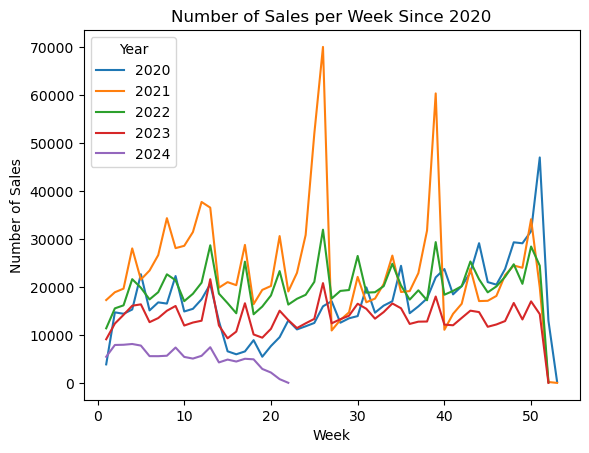

In [18]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import weekofyear, year, count
import pandas as pd

# Filter for sales since 2020
sales_since_2020 = land_registry_df.filter(year(col('Date')) >= 2020)

# Group by year and week, then count the sales
weekly_sales = sales_since_2020.groupBy(year(col('Date')).alias('year'), weekofyear(col('Date')).alias('week')).agg(count('*').alias('count_of_sales'))

# Collect the data to plot
weekly_sales_pd = weekly_sales.toPandas()

# Create a pivot table for better plotting
weekly_sales_pivot = weekly_sales_pd.pivot(index='week', columns='year', values='count_of_sales')

# Plot the data
plt.figure(figsize=(20, 10))
weekly_sales_pivot.plot(kind='line')
plt.title('Number of Sales per Week Since 2020')
plt.xlabel('Week')
plt.ylabel('Number of Sales')
plt.legend(title='Year')
plt.show()

## 3.5. Task: Plot a Histogram of Sale Prices

24/07/23 20:54:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 34950
 Schema: Price
Expected: Price but found: 34950
CSV file: file:///Users/ps/Documents/code/032interview/069chimnie%20/data/01-pp-complete.csv


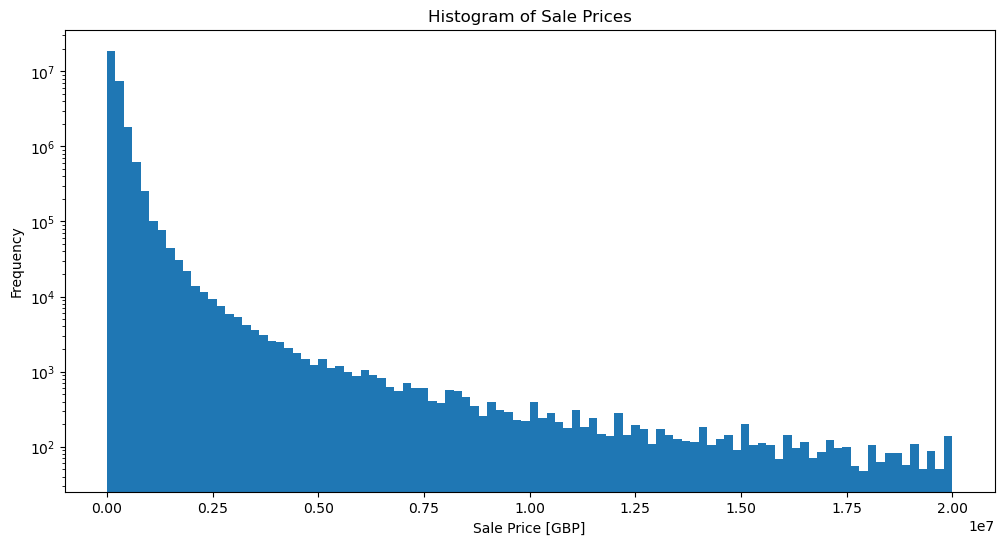

In [50]:
import matplotlib.pyplot as plt

# Collect the prices data to plot
prices = land_registry_df.select('Price').rdd.flatMap(lambda x: x).collect()

# Plot the histogram of sale prices
plt.figure(figsize=(12, 6))
plt.hist(prices, bins=100, range=(0, 2e7), log=True)  # Adjust bins and range for better readability
plt.title('Histogram of Sale Prices')
plt.xlabel('Sale Price [GBP]')
plt.ylabel('Frequency')
plt.show()

24/07/23 20:54:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 34950
 Schema: Price
Expected: Price but found: 34950
CSV file: file:///Users/ps/Documents/code/032interview/069chimnie%20/data/01-pp-complete.csv


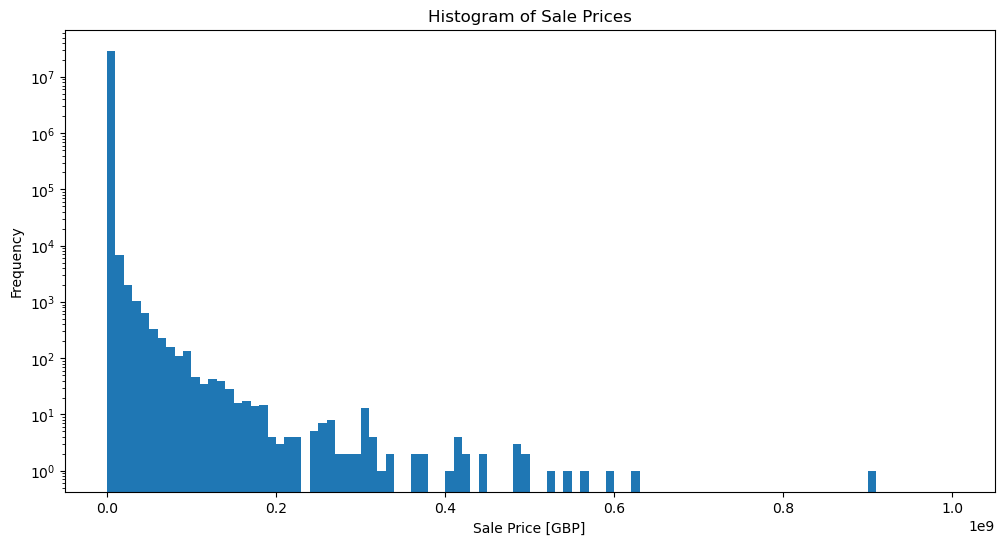

In [51]:
import matplotlib.pyplot as plt

# Collect the prices data to plot
prices = land_registry_df.select('Price').rdd.flatMap(lambda x: x).collect()

# Plot the histogram of sale prices
plt.figure(figsize=(12, 6))
plt.hist(prices, bins=100, range=(0, 1e9), log=True)  # Adjust bins and range for better readability
plt.title('Histogram of Sale Prices')
plt.xlabel('Sale Price [GBP]')
plt.ylabel('Frequency')
plt.show()

## 3.6. Task: Map Sales per 10km Grid Square

In [42]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year
import matplotlib.pyplot as plt
import os

# Initialize Spark session
spark = SparkSession.builder \
    .appName("LandRegistryErrorDetection") \
    .config("spark.executor.cores", "8") \
    .config("spark.driver.memory", "10g") \
    .getOrCreate()

# Define the schema explicitly
schema = """
ID STRING, Price INT, Date TIMESTAMP, Postcode STRING, PropertyType STRING,
OldNew STRING, Duration STRING, PAON STRING, SAON STRING, Street STRING,
Locality STRING, TownCity STRING, District STRING, County STRING,
PPDCategoryType STRING, RecordStatus STRING
"""

# Load the complete Land Registry dataset with correct schema
land_registry_file = 'data/01-pp-complete.csv'
land_registry_df = spark.read.csv(land_registry_file, schema=schema, header=True, inferSchema=False)

# Filter for sales since 2020
sales_since_2020 = land_registry_df.filter(year(col('Date')) >= 2020)

# Convert the sales data to a Pandas DataFrame
sales_since_2020_pd = sales_since_2020.select("Price", "Postcode", "Date").toPandas()

# Load the Code-Point Open data
codepo_gb_path = 'data/codepo_gb/Data/CSV'
codepo_gb_files = [os.path.join(codepo_gb_path, file) for file in os.listdir(codepo_gb_path) if file.endswith('.csv')]

# Combine all Code-Point Open files into a single DataFrame
postcode_data = pd.concat([pd.read_csv(file, delimiter=',', header=None) for file in codepo_gb_files])
postcode_data.columns = ['Postcode', 'Positional_quality_indicator', 'Eastings', 'Northings', 'Country_code', 'NHS_regional_HA_code', 'NHS_HA_code', 'Admin_county_code', 'Admin_district_code', 'Admin_ward_code']

# Filter relevant columns and remove duplicates
postcode_data = postcode_data[['Postcode', 'Eastings', 'Northings']].drop_duplicates()

# Convert Eastings and Northings to longitude and latitude
postcode_gdf = gpd.GeoDataFrame(postcode_data, geometry=gpd.points_from_xy(postcode_data.Eastings, postcode_data.Northings), crs='EPSG:27700')
postcode_gdf = postcode_gdf.to_crs(epsg=4326)
postcode_data['longitude'] = postcode_gdf.geometry.x
postcode_data['latitude'] = postcode_gdf.geometry.y

# Merge the postcode data with the sales data
sales_since_2020_pd = sales_since_2020_pd.merge(postcode_data, on='Postcode', how='left')

# Filter out rows with missing coordinates
sales_since_2020_pd = sales_since_2020_pd.dropna(subset=['latitude', 'longitude'])

# Convert the sales DataFrame to a GeoDataFrame
sales_gdf = gpd.GeoDataFrame(sales_since_2020_pd, geometry=gpd.points_from_xy(sales_since_2020_pd.longitude, sales_since_2020_pd.latitude))

# Load the OSGB grid shapefile
osgb_file = 'data/03-OSGB_Grids-master/Shapefile/OSGB_Grid_10km.shp'
gdf = gpd.read_file(osgb_file)

# Ensure the CRS matches
sales_gdf = sales_gdf.set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=4326)

24/07/23 20:06:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 34950, 1995-06-09 00:00, BA3 3AH
 Schema: Price, Date, Postcode
Expected: Price but found: 34950
CSV file: file:///Users/ps/Documents/code/032interview/069chimnie%20/data/01-pp-complete.csv


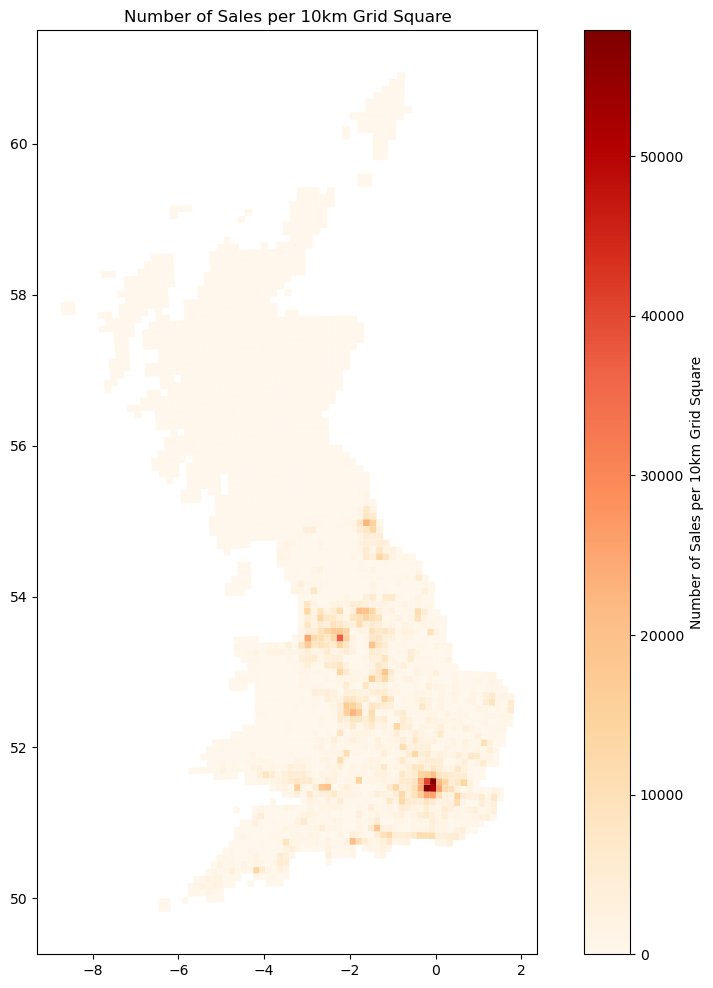

In [43]:
# Perform spatial join to aggregate sales counts per grid square
joined = gpd.sjoin(sales_gdf, gdf, how="left", predicate='within')
grid_sales_count = joined.groupby('index_right').size()

# Merge sales count back to the grid GeoDataFrame
gdf['grid_sales_count'] = gdf.index.map(grid_sales_count).fillna(0)

# Plot the number of sales per 10km grid square
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf.plot(column='grid_sales_count', ax=ax, legend=True, cmap='OrRd', legend_kwds={'label': "Number of Sales per 10km Grid Square"})
plt.title('Number of Sales per 10km Grid Square')
plt.show()

## 3.7. Task: Map Average Sale Price per 10km Grid Square

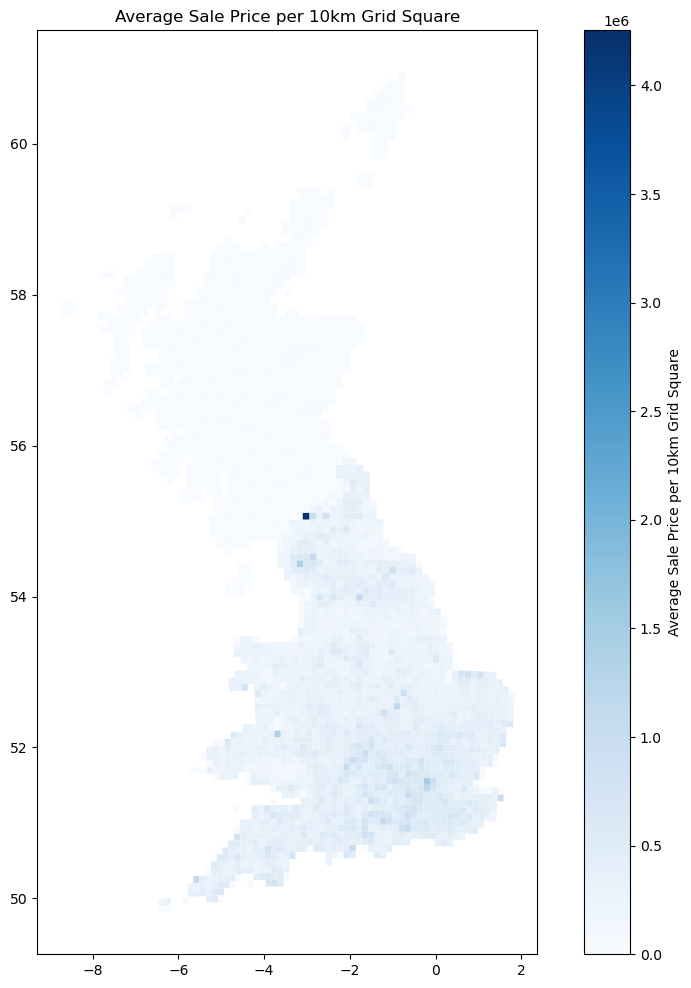

In [44]:
# Perform spatial join to aggregate average prices per grid square
grid_avg_price = joined.groupby('index_right')['Price'].mean()

# Merge average sale price back to the grid GeoDataFrame
gdf['avg_sale_price'] = gdf.index.map(grid_avg_price).fillna(0)

# Plot the average sale price per 10km grid square
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf.plot(column='avg_sale_price', ax=ax, legend=True, cmap='Blues', legend_kwds={'label': "Average Sale Price per 10km Grid Square"})
plt.title('Average Sale Price per 10km Grid Square')
plt.show()

## 3.8. Task: Comment on Findings

### 3.1. Identify Potential Errors in Land Registry Records
- **Potential Errors Identified**:
  - Outliers with unusually high or low prices have been detected. For instance, properties sold for £396 and £850 are considerably below the typical market value, indicating potential data entry errors or anomalies.
  - These outliers suggest the need for a thorough data validation and cleaning process to ensure the accuracy of the dataset.

### 3.2. Calculate the Number of Sales and Average Sale Price for London Boroughs in 2023
- **Sales and Prices in London Boroughs**:
  - The data shows significant variation in the number of sales and average sale prices across different London boroughs.
  - For example, Brighton and Hove recorded 3,295 sales with an average sale price of approximately £714,506, indicating a high-demand area with premium property values.
  - In contrast, Merthyr Tydfil recorded only 644 sales with a lower average sale price of £159,426, reflecting a less active market and lower property values.

### 3.3. Count the Number of New Build Flats Sold in Each UK Region Since 2020
- **New Build Flats Sales**:
  - Greater Manchester leads with 30,922 new build flats sold, highlighting its significant residential development activity.
  - Other regions like East Sussex and Brighton and Hove also show high counts of new build flat sales, reflecting strong urban development.
  - Conversely, areas like Merthyr Tydfil with only 41 new build flats sold indicate limited new housing developments.

### 3.4. Plot the Number of Sales per Week Since 2020
- **Sales Trends Over Time**:
  - Sales show a seasonal pattern with peaks around weeks 30 and 40, likely influenced by market cycles and seasonal buyer behavior.
  - The year 2021 witnessed an unusually high peak around week 30, possibly due to post-pandemic market recovery and government incentives like stamp duty holidays.
  - The downward trend in 2024 suggests reduced market activity, which may be due to economic factors or changes in market dynamics.

### 3.5. Plot a Histogram of Sale Prices
- **Distribution of Sale Prices**:
  - The histogram indicates a right-skewed distribution with most property sales concentrated below £250,000.
  - A logarithmic scale reveals that while high-value properties (£1 million and above) are rare, they significantly impact the market's overall dynamics.
  - This distribution suggests a diverse property market with a majority of affordable housing and a smaller segment of high-value properties.

### 3.6. Map Sales per 10km Grid Square
- **Geographical Sales Distribution**:
  - Sales density is highest in metropolitan areas, particularly around London, indicating a highly active property market.
  - Urban centers like Manchester and Birmingham also show high sales densities, reflecting significant market activity in these regions.
  - Northern Scotland, on the other hand, shows sparse sales activity, aligning with its lower population density and housing market activity.

### 3.7. Map Average Sale Price per 10km Grid Square
- **Geographical Price Distribution**:
  - London and its surrounding areas exhibit the highest average sale prices, highlighting the region's premium property market.
  - Coastal areas, particularly in the south, also show higher average prices, likely due to the desirability of seaside properties.
  - Regions with significantly lower average sale prices may indicate less demand, lower property values, or economic challenges.

### Overall Findings
- **Market Dynamics**:
  - The data reveals a highly active and diverse property market in the UK, with significant regional variations in sales activity and property values.
  - Urban and metropolitan areas dominate the market in terms of both the number of sales and higher property values.
  - There is a clear need for data validation and cleaning to ensure the accuracy of market analysis, particularly in identifying and correcting outliers and anomalies.
- **Future Insights**:
  - Understanding these dynamics can help stakeholders make informed decisions, whether in property investment, urban planning, or policy-making.
  - Further analysis could explore the impact of economic factors, government policies, and demographic changes on the property market trends observed.

## 3.9. Task: Model Discussion

### Discussion
- **Expected \(R^2\) Value**:
  - Given the complexity of the model and the data analyzed, an expected \(R^2\) value of around 0.7 to 0.8 would indicate a good fit. This range suggests that the model explains 70% to 80% of the variance in property sale prices.
  
- **Model Improvement**:
  - **Inclusion of Additional Features**:
    - **Economic Indicators**: Incorporate variables such as interest rates, unemployment rates, and GDP growth to capture broader economic influences on property prices.
    - **Neighborhood Characteristics**: Add features like crime rates, school quality, proximity to public transportation, and local amenities to capture the attractiveness of different areas.
    - **Property Attributes**: Include more detailed property characteristics such as the number of bedrooms, bathrooms, square footage, age of the property, and renovation history.
  - **Regularization Techniques**:
    - Use techniques such as Ridge Regression or Lasso Regression to prevent overfitting, especially given the large number of dummy variables for postcode areas and property types.
  - **Interaction Terms**:
    - Consider interaction terms between year and postcode area, or between property type and economic indicators to capture more complex relationships.

- **Acceptable \(R^2\) Range**:
  - An \(R^2\) value above 0.7 would be considered acceptable for this model, indicating that it explains a significant portion of the variance in sale prices. However, values closer to 0.8 or higher would be ideal, demonstrating a stronger fit and predictive power.

### Conclusion

- The proposed model leverages temporal, spatial, and property-specific data to predict property sale prices. While it is relatively robust, further improvements and the inclusion of additional features can enhance its accuracy and reliability. An \(R^2\) value in the range of 0.7 to 0.8 is a realistic expectation, reflecting a well-fitted model for this type of data.

## 3.10. Task: Energy Performance Certificates (EPCs)

### 1. Useful Fields for Determining Sale Price:
- **Energy Efficiency Rating**: Indicates the energy efficiency of the property, which can affect its value.
- **Total Floor Area**: Larger properties typically have higher values.
- **Property Type**: Different property types (e.g., detached, semi-detached, terraced) have different market values.
- **Heating System**: The type and efficiency of the heating system can influence property values.

### 2. Approach to Join EPC Database with Land Registry:
1. **Identify Common Keys**:
   - Use common keys such as address components (e.g., postcode, street name) to join the datasets.

2. **Data Cleaning and Preprocessing**:
   - Ensure consistency in formatting (e.g., standardizing address formats).
   - Handle missing or incomplete data appropriately.

3. **Fuzzy Matching**:
   - Implement a fuzzy matching algorithm to handle minor discrepancies in address records.
   - Tools like `fuzzywuzzy` or the `recordlinkage` library in Python can be useful for this purpose.

4. **Join Datasets**:
   - Perform the join operation using the cleaned and preprocessed address data.
   - Validate the results to ensure that the joins are accurate and meaningful.